In [1]:
from entities import *
from constants import TEAMS_DATA, STAT_EFFECTS

import time
import requests
from bs4 import BeautifulSoup, Comment

import dowhy
from tqdm import tqdm, trange

import os
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings

# Suppress specific pandas FutureWarnings regarding Series.__getitem__
warnings.filterwarnings("ignore", category=FutureWarning, message=".*Series.__getitem__ treating keys as positions is deprecated.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*The default of observed=False is deprecated.*")

c:\Users\amgal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(TEAMS_DATA, 'rb') as f:
    teams = pickle.load(f)

Getting a collection of 5 players based on how often they play:

In [3]:
dfs = []

for team in tqdm(teams.keys()):
    dfs.append(teams[team].causal_df)

df = pd.concat(dfs, ignore_index=True)
df.dropna(inplace=True)
df.head()

100%|██████████| 35/35 [00:00<?, ?it/s]


,Team,Opp_Name,Tm,Opp_Score,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,oFG,oFGA,oFG%,o3P,o3PA,o3P%,o2P,o2PA,o2P%,oeFG%,oFT,oFTA,oFT%,oORB,oDRB,oTRB,oAST,oSTL,oBLK,oTOV,oPF
0,Abilene Christian,McMurry,92.0,55.0,34.0,69.0,0.493,6.0,20.0,0.300,28.0,49.0,0.571,0.536,18.0,26.0,0.692,17.0,34.0,51.0,21.0,7.0,7.0,13.0,15.0,18.0,63.0,0.286,8.0,31.0,0.258,10.0,32.0,0.313,0.349,11.0,15.0,0.733,7.0,18.0,25.0,10.0,6.0,5.0,16.0,20.0
1,Abilene Christian,Omaha,73.0,71.0,25.0,57.0,0.439,7.0,21.0,0.333,18.0,36.0,0.500,0.500,16.0,21.0,0.762,9.0,18.0,27.0,15.0,8.0,3.0,14.0,23.0,21.0,45.0,0.467,6.0,19.0,0.316,15.0,26.0,0.577,0.533,23.0,31.0,0.742,3.0,16.0,19.0,10.0,11.0,3.0,15.0,20.0
2,Abilene Christian,SW Adventist,104.0,63.0,43.0,68.0,0.632,9.0,22.0,0.409,34.0,46.0,0.739,0.699,9.0,12.0,0.750,11.0,23.0,34.0,26.0,9.0,3.0,11.0,16.0,22.0,50.0,0.440,4.0,15.0,0.267,18.0,35.0,0.514,0.480,15.0,18.0,0.833,4.0,11.0,15.0,6.0,7.0,0.0,19.0,12.0
3,Abilene Christian,Stephen F. Austin,66.0,76.0,24.0,57.0,0.421,2.0,10.0,0.200,22.0,47.0,0.468,0.439,16.0,19.0,0.842,8.0,27.0,35.0,12.0,4.0,5.0,10.0,21.0,24.0,53.0,0.453,13.0,23.0,0.565,11.0,30.0,0.367,0.575,15.0,26.0,0.577,4.0,22.0,26.0,14.0,5.0,5.0,7.0,15.0
4,Abilene Christian,Texas State,49.0,63.0,17.0,55.0,0.309,5.0,15.0,0.333,12.0,40.0,0.300,0.355,10.0,19.0,0.526,12.0,15.0,27.0,6.0,14.0,5.0,14.0,19.0,21.0,46.0,0.457,5.0,8.0,0.625,16.0,38.0,0.421,0.511,16.0,22.0,0.727,10.0,23.0,33.0,8.0,11.0,9.0,18.0,15.0


## Building our DAG

In [4]:
graph = """
digraph{

Tm;
STL -> oTOV;
STL -> PF -> oFTA -> oFT -> Opp_Score;

BLK -> o2P;
BLK -> o3P;
BLK -> oPF;

TOV -> 3PA -> 3P -> Tm;
TOV -> 2PA -> 2P -> Tm;
TOV -> o3PA -> o3P -> Opp_Score;
TOV -> o2PA -> o2P -> Opp_Score;

ORB -> 3PA;
ORB -> 2PA;

DRB -> o2PA;
DRB -> o3PA;
DRB -> TOV;

Opp_Score;
oSTL -> TOV;
oSTL -> oPF -> FTA -> FT -> Tm;

oBLK -> 2P;
oBLK -> 3P;
oBLK -> PF;

oTOV -> 3PA -> 3P -> Tm;
oTOV -> 2PA -> 2P -> Tm;
oTOV -> o3PA -> o3P -> Opp_Score;
oTOV -> o2PA -> o2P -> Opp_Score;

oORB -> o3PA;
oORB -> o2PA;

oDRB -> 2PA;
oDRB -> 3PA;
oDRB -> oTOV;
}
"""

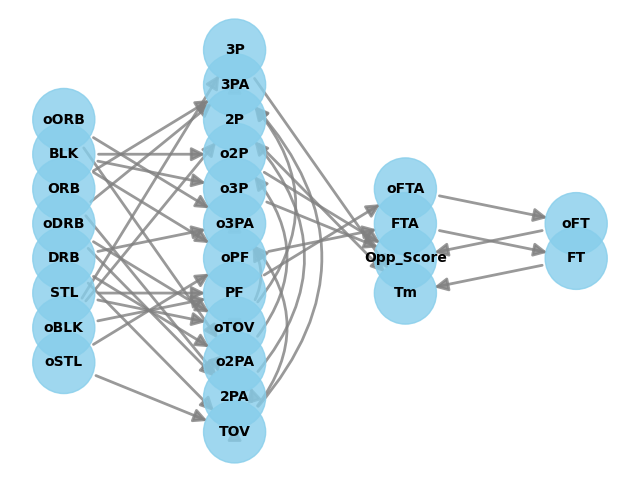

In [5]:
model = dowhy.CausalModel(data=df, graph=graph, treatment="2P",outcome="Tm")
model.view_model()

Getting a better view...

In [ ]:
import graphviz
# Stylized Graph below generated from the following chat: https://gemini.google.com/share/935c413b5c93

graphviz_graph = """
digraph {
    // Styling for readability
    graph [rankdir=LR, splines=curved];
    node [shape=box, style="filled,rounded", fillcolor="#f0f0f0"];

    Tm;
    STL -> oTOV;
    STL -> PF -> oFTA -> oFT -> Opp_Score;

    // Quotes added below for nodes starting with numbers
    BLK -> o2P;
    BLK -> o3P;
    BLK -> oPF;

    TOV -> "3PA" -> "3P" -> Tm;
    TOV -> "2PA" -> "2P" -> Tm;
    TOV -> o3PA -> o3P -> Opp_Score;
    TOV -> o2PA -> o2P -> Opp_Score;

    ORB -> "3PA";
    ORB -> "2PA";

    DRB -> o2PA;
    DRB -> o3PA;
    DRB -> TOV;

    Opp_Score;
    oSTL -> TOV;
    oSTL -> oPF -> FTA -> FT -> Tm;

    oBLK -> "2P";
    oBLK -> "3P";
    oBLK -> PF;

    oTOV -> "3PA" -> "3P" -> Tm;
    oTOV -> "2PA" -> "2P" -> Tm;
    oTOV -> o3PA -> o3P -> Opp_Score;
    oTOV -> o2PA -> o2P -> Opp_Score;

    oORB -> o3PA;
    oORB -> o2PA;

    oDRB -> "2PA";
    oDRB -> "3PA";
    oDRB -> oTOV;
}
"""

dot = graphviz.Source(graphviz_graph)
dot.render('graphviz_graph', view=True, format='png')

'graphviz_graph.png'

## Estimating Average Causal Effects

In [6]:
OUTCOMES = ['Tm', 'Opp_Score']

VARIABLES = ['2P',  '2PA',  '3P',  '3PA',  'FT',  'FTA',  'STL',  'BLK',  'TOV',  'PF',  'ORB',  'DRB',  # Team Stats
            'o2P', 'o2PA', 'o3P', 'o3PA', 'oFT', 'oFTA', 'oSTL', 'oBLK', 'oTOV', 'oPF', 'oORB', 'oDRB']  # Opponent Stats

In [7]:
treatment_effects = {}
for treatment in tqdm(VARIABLES):
    
    outcome_effects = {}
    for outcome in OUTCOMES:

        # Creating the Causal Model
        model = dowhy.CausalModel(
            data=df,
            graph=graph,
            treatment=treatment,
            outcome=outcome
        )

        # Identifying the Estimand
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

        # Estimating the Estimand
        estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 target_units="ate")
        
        outcome_effects[outcome] = float(estimate.value)
    treatment_effects[treatment] = outcome_effects
        

100%|██████████| 24/24 [09:42<00:00, 24.27s/it]


In [8]:
treatment_effects

{'2P': {'Tm': 1.9986433355509163, 'Opp_Score': 0.0},
 '2PA': {'Tm': 1.2178537004254437, 'Opp_Score': 0.0},
 '3P': {'Tm': 3.000105697388342, 'Opp_Score': 0.0},
 '3PA': {'Tm': 0.9472771566991725, 'Opp_Score': 0.0},
 'FT': {'Tm': 1.100958029691398, 'Opp_Score': 0.0},
 'FTA': {'Tm': 0.8505050456751846, 'Opp_Score': 0.0},
 'STL': {'Tm': 1.0461847437303788, 'Opp_Score': -0.7792945994723794},
 'BLK': {'Tm': 0.06919072956283401, 'Opp_Score': -0.5606392115439149},
 'TOV': {'Tm': -0.8837668495638553, 'Opp_Score': 0.8140066425891774},
 'PF': {'Tm': 0.0, 'Opp_Score': 1.112083535319222},
 'ORB': {'Tm': 0.18214230608968762, 'Opp_Score': 0.0},
 'DRB': {'Tm': 0.8515540851007373, 'Opp_Score': -0.8482811834190187},
 'o2P': {'Tm': 0.0, 'Opp_Score': 2.0020565121017526},
 'o2PA': {'Tm': 0.0, 'Opp_Score': 0.9823154279590369},
 'o3P': {'Tm': 0.0, 'Opp_Score': 2.976299923120834},
 'o3PA': {'Tm': 0.0, 'Opp_Score': 0.8889784736679829},
 'oFT': {'Tm': 0.0, 'Opp_Score': 0.9857689378246519},
 'oFTA': {'Tm': 0.0, '

In [10]:
with open(STAT_EFFECTS, 'wb') as f:
    pickle.dump(treatment_effects, f)